In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2
from scipy.stats import norm

from tqdm import tqdm
import os.path as path
import wget

# Modelo de Ajuste

Definimos un modelo matemático para ajustar los datos, dicha función depende de la variable $x$ y de dos parámetros de ajuste $m$ y $b$.

$$ Y_{fit} = f(x) = mx + b $$

## Función de Costo

Para cuantificar el nivel de acuerdo entre los datos observados y el modelo usamos una función de costo:

$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - Y_{fit}\right)^{2} }{2\sigma_{i}^{2}}$$
$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - (m X_{i}+b)\right)^{2} }{2\sigma_{i}^{2}}$$

In [69]:
!rm Data/*
file = 'Data/data.dat'
#url = 'https://raw.githubusercontent.com/asegura4488/DataBase/main/MetodosComputacionales/MCMC_Lineal.dat'
#url = 'https://raw.githubusercontent.com/asegura4488/DataBase/main/MetodosComputacionales/MCMC.dat'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'
if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

File loaded


In [70]:
def GetHisto(l,h = 0.2):
    
    xmin_, xmax_ = np.min(l), np.max(l)
    bines = np.arange(xmin_,xmax_+h,h)
    H, bins = np.histogram(l,bins=bines)
    w = np.diff(bins)
    m = bins[:-1] + 0.5*w[0] # Marcas de clase
    HNorm = H / np.sum(H*w)
    
    return H,HNorm,bins,m,w

In [71]:
data = np.loadtxt(Path_, comments='#')
x = data[:,0]
y = data[:,1]
n = len(x)

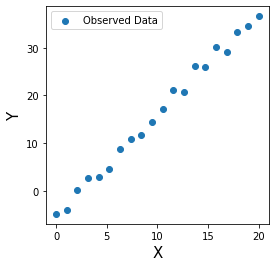

In [72]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
#ax.axhline(y=0.,c='r')
ax.set_xlabel('X',fontsize=15)
ax.set_ylabel('Y',fontsize=15)
ax.scatter(x,y,label='Observed Data')
ax.legend(loc=0)

In [73]:
def Model1(x,c):
    
    n = len(c)
    
    y = 0
    
    for i in range(n):
        y += c[i]*x**i
        
    return y

In [74]:
def Model2(x,c):
    y = c[0]*np.exp(c[1]*x)
    return y

In [75]:
def GetChi2(Model_,c):
    
    sigma = 1
    
    chi2 = np.sum( (y-Model_(x,c))**2/(2*sigma**2) )
    
    return chi2

In [76]:
def GetSeed( Np, Model_, min_ = 700 ):
    
    chi2 = min_ + 1
    
    while(chi2 > min_):
        x = np.random.uniform( -50,50, size=Np )
        chi2 = GetChi2( Model_, x )
        #print(chi2)
        
    return x

In [78]:
#GetSeed( 2, Model1 )

In [102]:
def Metropolis( Np = 3, Model_=Model1, delta = 1.5, NSteps=100, burned = 0  ):
    
    xt = np.ones( (NSteps +1 , Np) )
    
    xt[0] = GetSeed( Np = Np, Model_ = Model_ )
    
    print('--- seed found ---')
    
    for i in tqdm(range(1,NSteps-1)):
        
        xt[i,:] = xt[i-1,:] + (np.random.random(Np)-0.5)*delta
        
        future = np.exp( - GetChi2(Model_ = Model_, c = xt[i,:] ) )
        present = np.exp( - GetChi2(Model_ = Model_, c = xt[i-1,:] ) )
        
        alpha = np.minimum( 1, future/present )
        g = np.random.rand()
        
        if g < alpha:
            xt[i,:] = xt[i,:]
        else:
            xt[i,:] = xt[i-1,:]
           
    ii = NSteps - burned
    
    return xt[-ii:,:]

In [103]:
Np = 2
xt = Metropolis( Np = Np, Model_ = Model1, NSteps = int(1e5) )

  1%|          | 1117/99998 [00:00<00:18, 5440.91it/s]

--- seed found ---


100%|██████████| 99998/99998 [00:17<00:00, 5640.48it/s]


In [104]:
c_ = np.mean( xt, axis=0 )
print(c_)

[-5.12242372  2.12460903]


In [105]:
# Hallando los errores en los parametros
q = np.quantile(a = xt, q = [0.025,0.975], axis = 0)
print(q)

[[-5.97035966  2.04783285]
 [-4.23486278  2.19665528]]


In [106]:
errorsup = q[1] - c_
errorinf = c_ - q[0]
print(errorsup)
print(errorinf)

[0.88756094 0.07204625]
[0.84793593 0.07677618]


In [96]:
#print(xt)

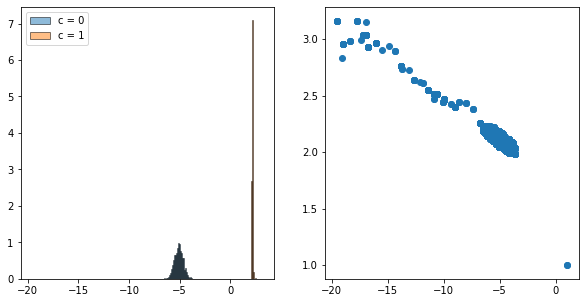

In [107]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

for i in range(len(xt[0,:])):
    
    _,H,_,m,w = GetHisto(xt[:,i], h=0.1)
    ax.bar(m,H,width=w, ec='k', alpha=0.5, label='c = %.0f'%(i))
    
l = ax.legend()

ax1.scatter(xt[:,0],xt[:,1])
#ax1.scatter(xt[:,0],xt[:,2])

In [23]:
#plt.hist(xt[:,2])

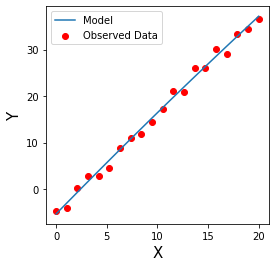

In [98]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)

ax.scatter(x,y,marker='o',color='r',label='Observed Data')

t = np.linspace(np.min(x),np.max(x),100)
ax.plot(t,Model1(t,c_),label='Model')

#ax.axhline(y=0.,c='r')
ax.set_xlabel('X',fontsize=15)
ax.set_ylabel('Y',fontsize=15)
ax.legend(loc=0)

In [99]:
Chi2 = GetChi2(Model_ = Model1, c=c_)
NChi2 = Chi2/(n-Np)
print(Chi2,NChi2)

11.280077396740543 0.6635339645141496


In [100]:
upper = chi2.ppf(0.95, df=n-Np)
print(upper)

27.58711163827534


In [101]:
prob = chi2.cdf(Chi2,df = n-Np)
pvalue = 1 - prob
print(pvalue)
print(norm.ppf(1-pvalue))

0.8416392254639454
-1.0012177456826132
